# Predicting Job Seekers in an Imbalanced Dataset

### By Daniel Jullien

## Table of contents
* [Introduction](#introduction)
* [Data Acquisition](#data)
* [Data Cleaning](#datacleaning)
* [Analysis](#analysis)
* [Classification Model](#prediction)
* [Conclusion](#conclusion)
* [References](#references)

## 1. Introduction <a name="introduction"></a>

In this project we will study a dataset  of Data Scientists, doing some necessary data cleaning, an exploratory data analysis and finally a model to predict whether they are looking for job change or not. This is an interesting use of Data Science for the HR Team. 

We will be working with an imbalanced dataset (which will be observed later) and when that is the case most machine learning techniques will almost ignore the minority class, classifying most of the data to the majority class. This is an issue, as typically it is performance on the minority class that is most important. We will explore ways to work with this kind of dataset as well.

#### Applied Models:
- Logistic Linear Regression
- KNN
- Logistic Regression
- Decision tree
- Random forest
- Ada Boost
- Gradient Boosting

#### Oversampling Techniques
- SMOTE
- Borderline-SMOTE

### Business Problem: 
A company which wants to hire data scientists among people who successfully pass some courses conducted by the company. Howerver, many people signup for their training. Therefore, the HR Team wants identify which of these candidates are truely looking for a new employment as it will reduce the cost and time of this selection as well as possibly increase the quality of training or planning the courses, being able to categorize the candidates and better instruct them during courses. 

There are some information avialable related to demographics, education and experience, obtained from candidates signup and courses enrollment.

### Problem Statment

HR wants to understand the factors that lead a person to leave current job. They are also interested in a model that can classify the candidates in job seekers or non-seekers.

### Data:

- enrollee_id : Unique ID for candidate
- city: City code
- city_ development _index : Developement index of the city (scaled)
- gender: Gender of candidate
- relevent_experience: Relevant experience of candidate
- enrolled_university: Type of University course enrolled if any
- education_level: Education level of candidate
- major_discipline :Education major discipline of candidate
- experience: Candidate total experience in years
- company_size: No of employees in current employer's company
- company_type : Type of current employer
- lastnewjob: Difference in years between previous job and current job
- training_hours: training hours completed
- target: 0 – Not looking for job change, 1 – Looking for a job change

## 2. Data Acquisition<a name="data"></a>

Importing libraries and loading csv file with the dataset.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.io as pio
import plotly.express as px

import missingno as msno

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score,f1_score, roc_auc_score, precision_score

from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

In [2]:
df_train = pd.read_csv('aug_train.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [5]:
print(f'The train dataset containts {df_train.shape[0]} rows and {df_train.shape[1]} columns.')

The train dataset containts 19158 rows and 14 columns.


## 3. Data Cleaning <a name="datacleaning"></a>

We will verify the need of dealing with:
- Missing values
- Duplicate rows
- Wrong data type

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

All the data types seems to be correct at a first look, however, we can easilly see that there are some missing values.<br>Let's verify which columns have missing values and also check for duplicated rows.

In [7]:
df_train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [8]:
df_train.duplicated().sum()

0

There are no duplicated rows, however there are a lot of missing values that need to be dealt with.

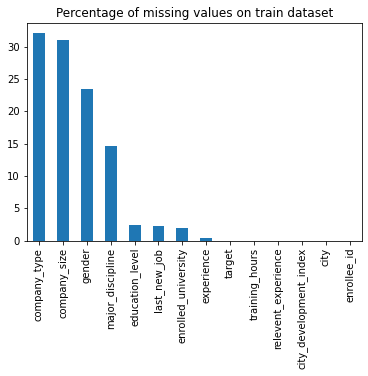

In [9]:
plt.figure()
((df_train.isnull().sum()*100/len(df_train)).sort_values(ascending=False)).plot(kind='bar')
plt.title('Percentage of missing values on train dataset')
plt.show()

For an easier use on the for cleaning new datasets in the future, once we define how we will deal with each missing value, we will create a function to clean the entire dataset. 

However, we need first to explore the columns with missing values to define the best strategy to fill them, if there is any good option apart from filling with "Unknown". We will also use 'missingno' library to explore the data.<br>
The first step is to investigate the interrelationship between the missing values, which can be usuful for filling them later.

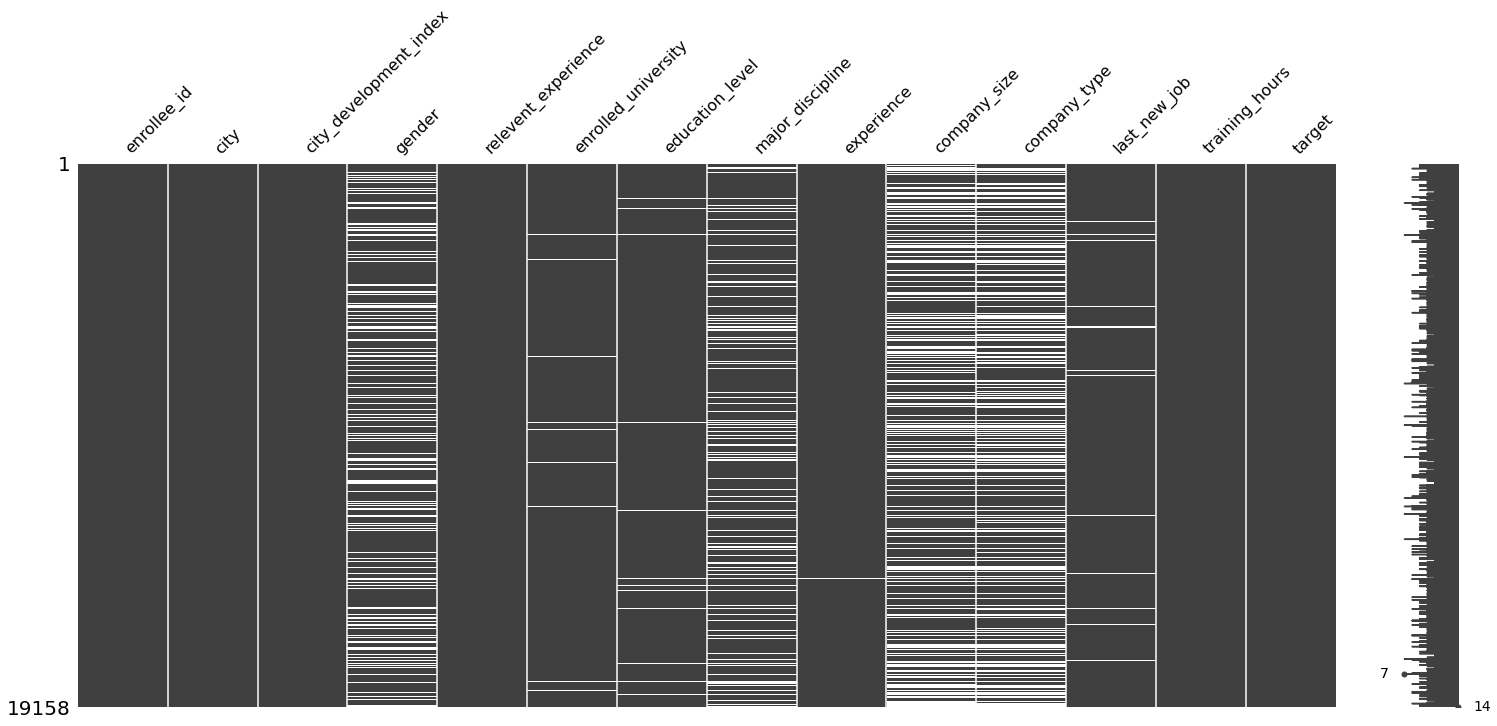

In [10]:
msno.matrix(df_train)
plt.show()

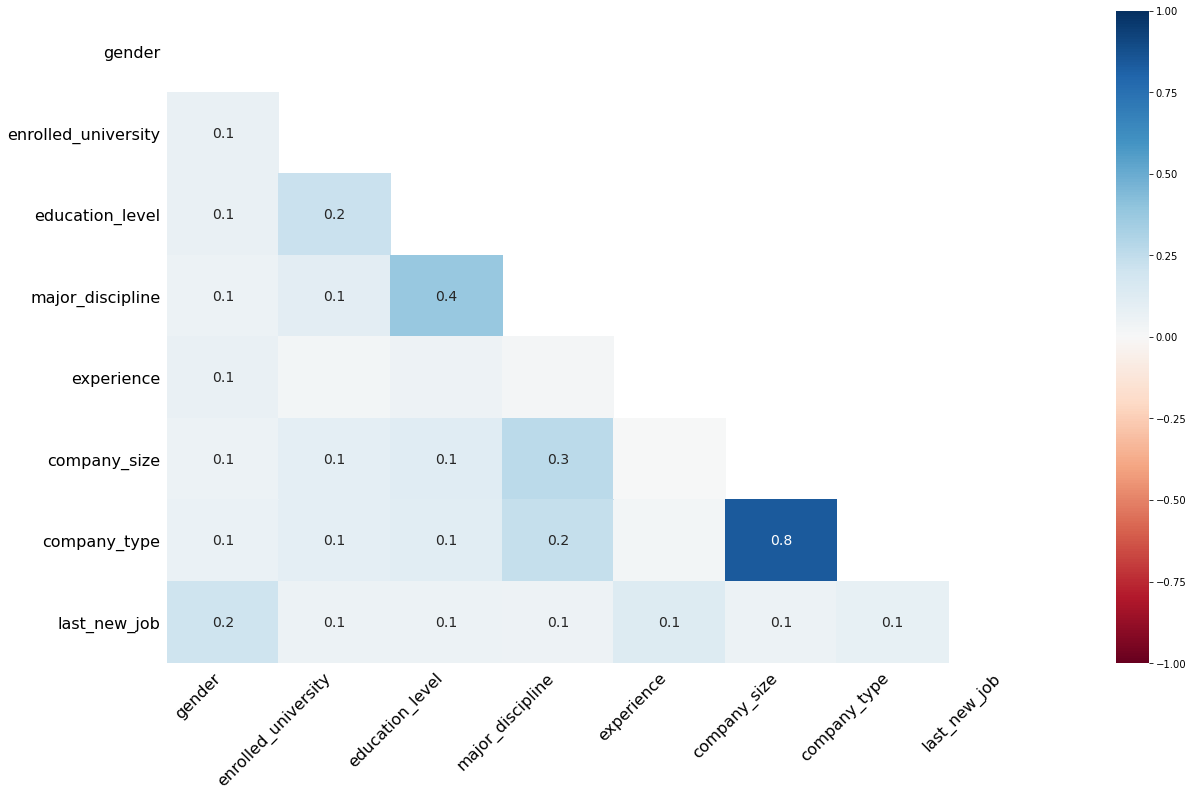

In [11]:
msno.heatmap(df_train)
plt.show()

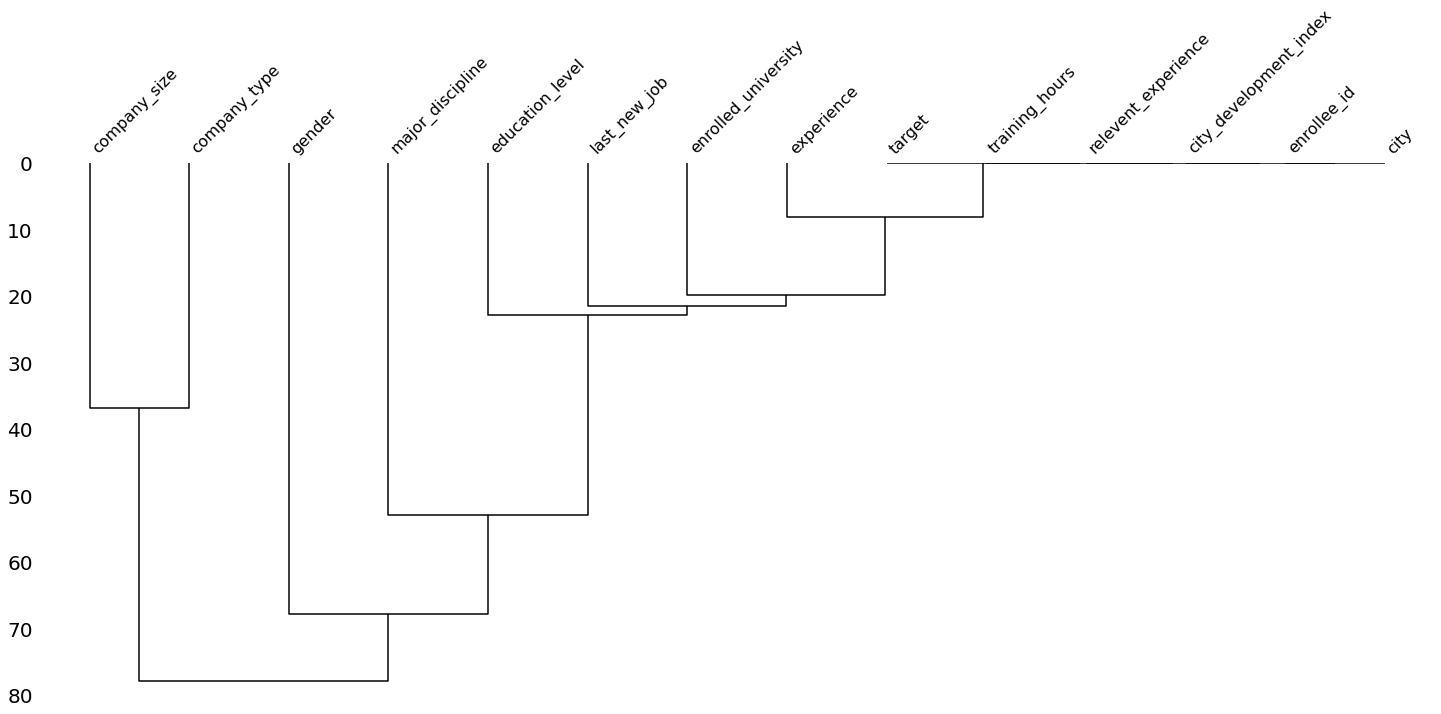

In [12]:
msno.dendrogram(df_train)
plt.show()

There is a clear relationship between the Company Size and Company Type missing values.

We will now explore the distribution of each individual value to infer the best strategy for each.<br>
Let's start with the Gender.

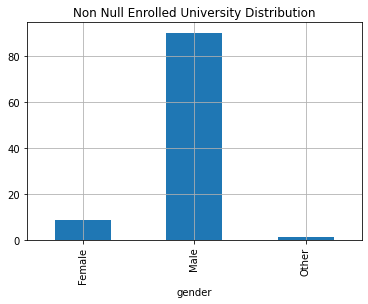

In [13]:
plt.figure()
(df_train.groupby('gender').count()['enrollee_id']*100/(df_train.groupby('gender').count()['enrollee_id'].sum())).plot(kind='bar',grid=True)
plt.title('Non Null Enrolled University Distribution')
plt.show()

We see that for the Gender, the majority of the Data Scientists who took courses on the company are male.

Surprisingly, around 23.5% of the data is missing. We can either fill the missing values with the mode (male) or a new category 'Unknown' can be created. We will chose in this case to fill it with the mode as more than 90% of the non null data is male.

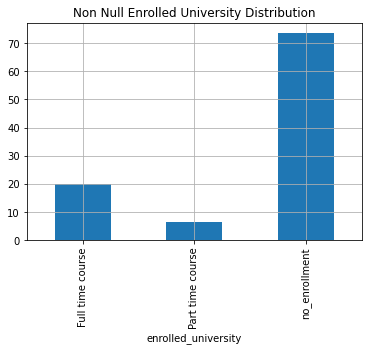

In [14]:
plt.figure()
(df_train.groupby('enrolled_university').count()['enrollee_id']*100/(df_train.groupby('enrolled_university').count()['enrollee_id'].sum())).plot(kind='bar',grid=True)
plt.title('Non Null Enrolled University Distribution')
plt.show()

There is only 2% of the data missing for the information regarding University Enrollment. Once again the mode will be used, as more than 70% were not enrolled in an University.

We will also replace the 'no_enrollment' for 'No enrollment' for better reading.

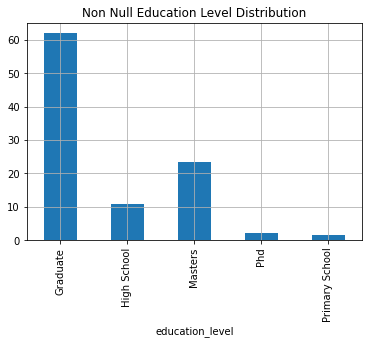

In [15]:
plt.figure()
(df_train.groupby('education_level').count()['enrollee_id']*100/(df_train.groupby('education_level').count()['enrollee_id'].sum())).plot(kind='bar',grid=True)
plt.title('Non Null Education Level Distribution')
plt.show()

Education Level has 2.4% missing values and the mode is Graduate. Similar to the University, we will fill with mode.

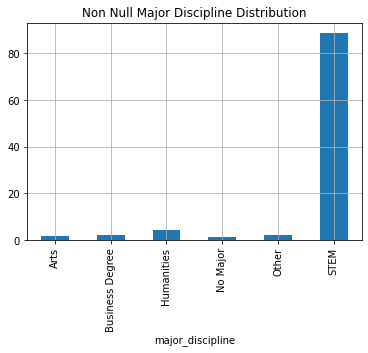

In [16]:
plt.figure()
(df_train.groupby('major_discipline').count()['enrollee_id']*100/(df_train.groupby('major_discipline').count()['enrollee_id'].sum())).plot(kind='bar',grid=True)
plt.title('Non Null Major Discipline Distribution')
plt.show()

Eventhough almost 15% of Major Discipline is missing, only less than 10% of the total data belong to another discipline, so we will fill the missing values with STEM. Also, the company could confirm that very few people who take their courses does not come from a degree programs in science, technology, engineering or mathematics.

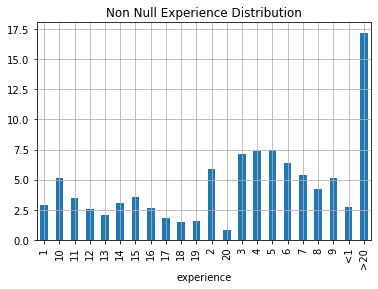

In [17]:
plt.figure()
(df_train.groupby('experience').count()['enrollee_id']*100/(df_train.groupby('experience').count()['enrollee_id'].sum())).plot(kind='bar',grid=True)
plt.title('Non Null Experience Distribution')
plt.show()

For the experience there are a lot of different categories and there are only 0.3% missing values.

We will also replace '<1' by 0 and '>20' by 20, and then convert the whole column to integer for a better analysis.<br>
As there are few values missing we will simply drop them instead of trying to predict their experience.

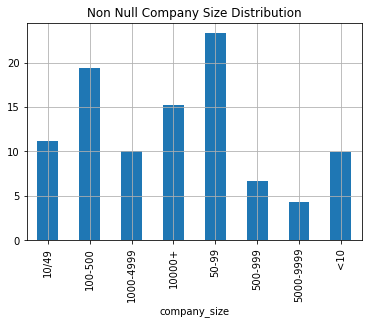

In [18]:
plt.figure()
(df_train.groupby('company_size').count()['enrollee_id']*100/(df_train.groupby('company_size').count()['enrollee_id'].sum())).plot(kind='bar',grid=True)
plt.title('Non Null Company Size Distribution')
plt.show()

31% of the Company Size values are missing. As we've seen a big correlation between the missing values of Company Size and Company Type, let's take a look at company type as well before deciding what to do.

We also notice that one of the categories should be '10-49' instead of '10/49', so it will also be fixed on our cleaning function.

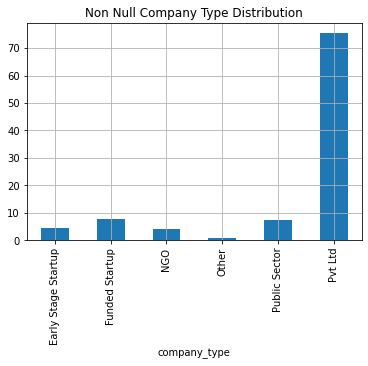

In [19]:
plt.figure()
(df_train.groupby('company_type').count()['enrollee_id']*100/(df_train.groupby('company_type').count()['enrollee_id'].sum())).plot(kind='bar',grid=True)
plt.title('Non Null Company Type Distribution')
plt.show()

32% of the values are missing, from the valid data more than 70% are 'Pvt Ltd'. 

If both Company Type and Company Size values are missing, we can assume that the reason if that the Data Scientist is not working in any company at the moment, so we will fill them with 0 for Company Size and 'None' for Company Type.

If either Company Type or Company Size is missing but the other one is filled, we will fill the missing value with 'Unknown'.



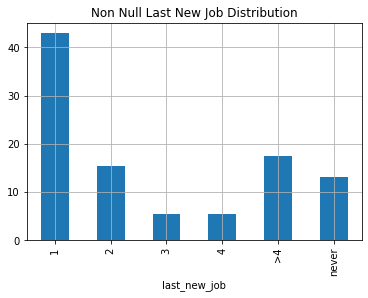

In [20]:
plt.figure()
(df_train.groupby('last_new_job').count()['enrollee_id']*100/(df_train.groupby('last_new_job').count()['enrollee_id'].sum())).plot(kind='bar',grid=True)
plt.title('Non Null Last New Job Distribution')
plt.show()

Only 2.2% of the Last New Job values are missing, however, as there is no clear way to fill it, in this case we will drop them.<br>
We will also replace 'never' by 'Never' for better reading.

Then, a function will be defined for an easier cleaning of the datasets.

In [21]:
def clean_NAN(df):
    df['gender'].fillna(df['gender'].mode()[0],inplace=True)
    
    df["enrolled_university"]=df["enrolled_university"].apply(lambda x: 'No enrollment' if x=='no_enrollment' else x)
    df["enrolled_university"].fillna(df["enrolled_university"].mode()[0],inplace=True)
    
    df["education_level"].fillna(df["education_level"].mode()[0],inplace=True)
    
    df["major_discipline"].fillna(df["major_discipline"].mode()[0], inplace=True)
    
    df['experience'] = df['experience'].apply(lambda x: '0' if x == '<1' else x)
    df['experience'] = df['experience'].apply(lambda x: '20' if x == '>20' else x)
    df['experience'] = df['experience'].apply(pd.to_numeric)
    
    df['company_size'] = df['company_size'].apply(lambda x: '10-49' if x == '10/49' else x)
    df["company_size"].fillna('Unknown',inplace=True)
    df["company_type"].fillna('Unknown',inplace=True)
    df['company_size'] = df.apply(lambda x: '0' if ((x['company_size'] == 'Unknown') & (x['company_type'] == 'Unknown')) else x['company_size'],axis=1)
    df['company_type'] = df.apply(lambda x: 'None' if x['company_size'] == '0' else x['company_type'],axis=1)
    
    df['last_new_job'] = df['last_new_job'].apply(lambda x: 'Never' if x == 'never' else x)
    df.dropna(subset=["last_new_job","experience"], inplace=True)

In [22]:
clean_NAN(df_train)

In [23]:
df_train.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

We successfully cleaned the dataset.

## 4. Analysis <a name="analysis"></a>

With the data cleaned, we will do some exploratory data analysis to better understand the factors that lead a Data Scientist to leave the current job. 

Before any analysis, we might expect to see some factors impacts:
- People with no relevant experience are mainly interested in a job chance, once they are looking for a job to acquire this experience.
- People with few years of experience are more likelly to be looking for a job change, while those more experienced may have already found a good company where they have a carrer plan.
- Company Size might also be a relevant feature, since some people working on smaller companies might be interested in moving to a bigger one, even if we know that there are people who enjoy working on smaller companies, such as startups.
- The time since the last job change might also aftect, as we expect those who recently changed are not yet looking for a new job and those that didn't change job for a long time might also be well established on their companies.

#### How many Data Scientists are looking for a new job

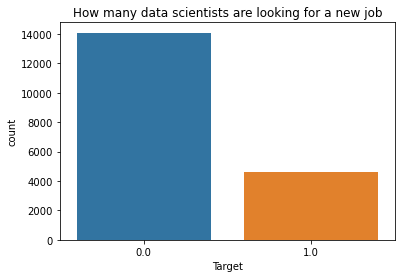

In [24]:
sns.countplot(data=df_train,x='target')
plt.title('How many data scientists are looking for a new job')
plt.xlabel('Target')
plt.show()

We have an imbalanced dataset!<br>
There are many more non job-seekers than job-seekers among the people who took courses in the company. This will have to be dealt with later on the Machine Learning development.

#### Correlation

We can first take a quick look at the correlation between the few numerical columns we have.

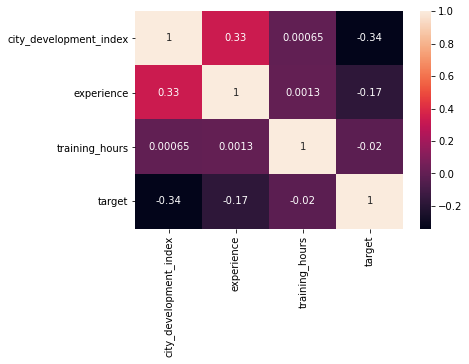

In [25]:
sns.heatmap(df_train.drop('enrollee_id',axis=1).corr(), annot=True)
plt.show()

City Development Index seems to be most relevent feature with a negative correlation.<br>
Experience surprisingly has a significant positive correlation with City Development Index.<br>
Training hours seems to have no correlation with any other numerical feature.

Let's see dive into these correlations a bit deeper.

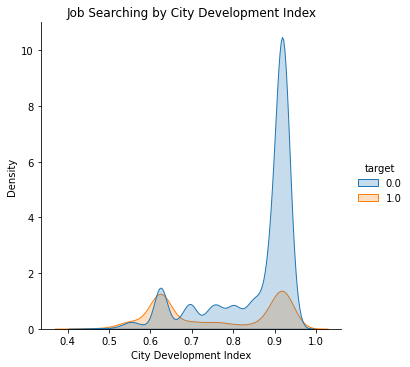

In [26]:
sns.displot(data=df_train,x='city_development_index',kind='kde',hue='target',fill=True)
plt.title('Job Searching by City Development Index')
plt.xlabel('City Development Index')
plt.show()

As we've seen, the negative correlation between the City Development Index can be seen as in cities with development index bellow around 0.66 there are more Data Scientists searching for a new job than non-searchers, while in cities with a higher development index the difference between those looking and not looking for a new job is huge. 

We also notice that there are much more data scientists in highly developed cities.

The City Development Index is then a significant factor to be considered when identifying the best candidates.

Let's now try to understand the relationship we found between experince and the city development index.

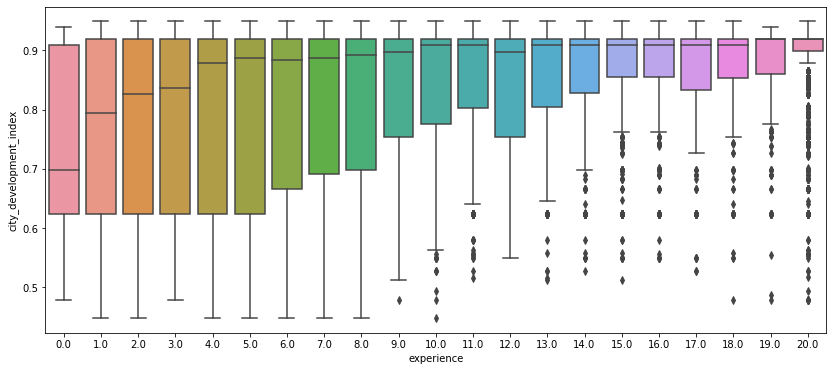

In [27]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_train,x='experience',y='city_development_index')
plt.show()

There is a clear trend of more experienced Data Scientists working on cities with higher Development Index, where are also located most of the best companies, while inexperienced Data Scientists are much more spread in different types of cities.

#### Gender distribution

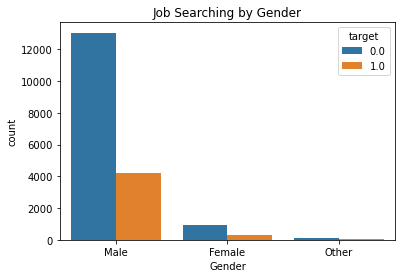

In [28]:
sns.countplot(data=df_train,x='gender',hue='target')
plt.title('Job Searching by Gender')
plt.xlabel('Gender')
plt.show()

As we've seen before, most of the data scientists that take courses at the company are male, so no clear trend based only on gender can be found.

#### How experienced and educated are the searchers

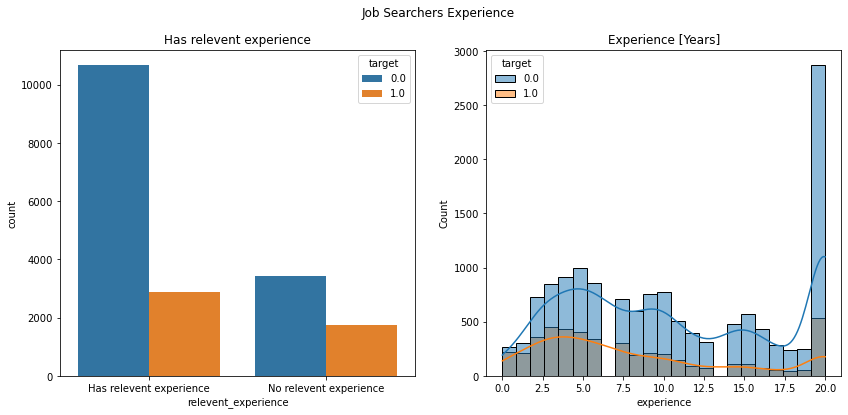

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
sns.countplot(ax=axes[0],data=df_train,x='relevent_experience',hue='target')
sns.histplot(ax=axes[1],data=df_train,x='experience',hue='target',kde=True)
fig.suptitle('Job Searchers Experience')
axes[0].set_title('Has relevent experience')
axes[1].set_title('Experience [Years]')
plt.show()

Many of the data scientists seeking for a new job have no relevant experience or have few years of experience, which confirm our hypothesis. Those are also two important features for HR Team to consider on a first analysis.
Among those with more experience we find fewer looking for a new job. 

It is also interesting to see that there are many very experienced Data Scientists taking courses on the company as well.

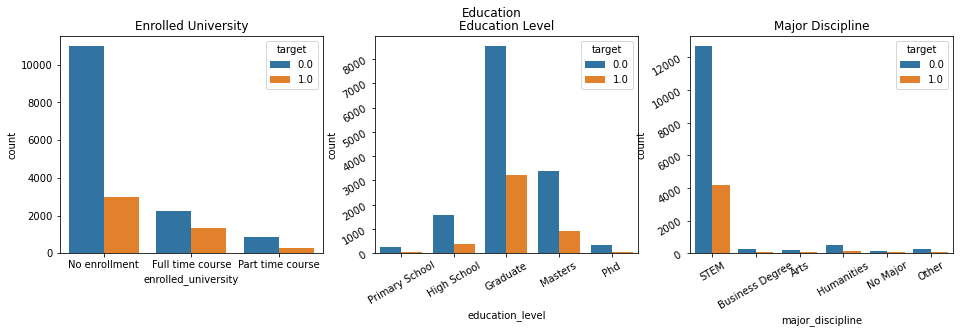

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16,4))
sns.countplot(ax=axes[0],data=df_train,x='enrolled_university',hue='target')
sns.countplot(ax=axes[1],data=df_train,x='education_level',hue='target',order=[ 'Primary School','High School','Graduate', 'Masters',  'Phd'])
sns.countplot(ax=axes[2],data=df_train,x='major_discipline',hue='target')
fig.suptitle('Education')
axes[0].set_title('Enrolled University')
axes[1].set_title('Education Level')
axes[1].tick_params(labelrotation=30)
axes[2].set_title('Major Discipline')
axes[2].tick_params(labelrotation=30)
plt.show()

Most of the data scientists are have a graduate or master and the vast majority major discipline was science, technology, engineering or mathematics (STEM).

We see that among the candidates enrolled in a full time course and those graduates there proportionally more job-seekers than on the those that belong to other categories. So these categories are also important to be verified. 

#### How does the current Company affect job searches

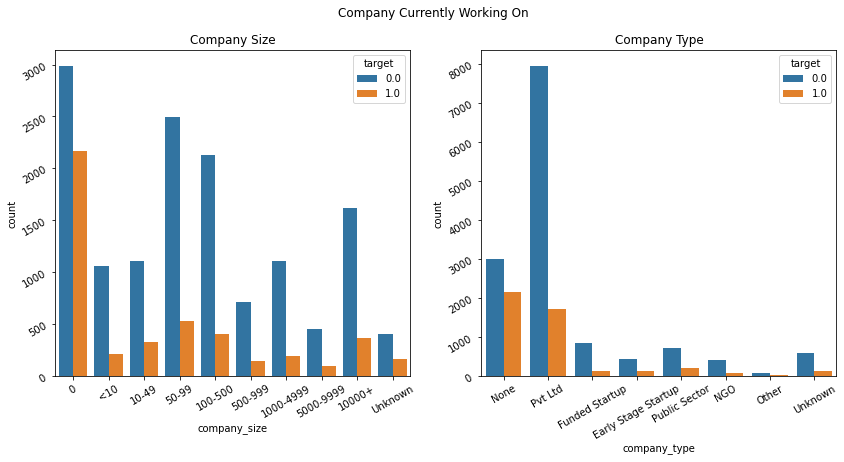

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
sns.countplot(ax=axes[0],data=df_train,x='company_size',hue='target',order=['0','<10','10-49','50-99','100-500','500-999','1000-4999','5000-9999','10000+','Unknown'])
sns.countplot(ax=axes[1],data=df_train,x='company_type',hue='target',order=['None','Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Public Sector', 'NGO','Other','Unknown'])
fig.suptitle('Company Currently Working On')
axes[0].set_title('Company Size')
axes[1].set_title('Company Type')
axes[0].tick_params(labelrotation=30)
axes[1].tick_params(labelrotation=30)
plt.show()

The majority of the candidates not working on a company are looking for a new job. This also confirms our cleaning method of assuming that those who did not fill both company type and company size are not working.

However, when looking for those already working on a company, differently from what we guessed, we don't see many more data scientists from smaller companies than bigger companies looking for a job change.

#### Is there any relationship between company size and experience?

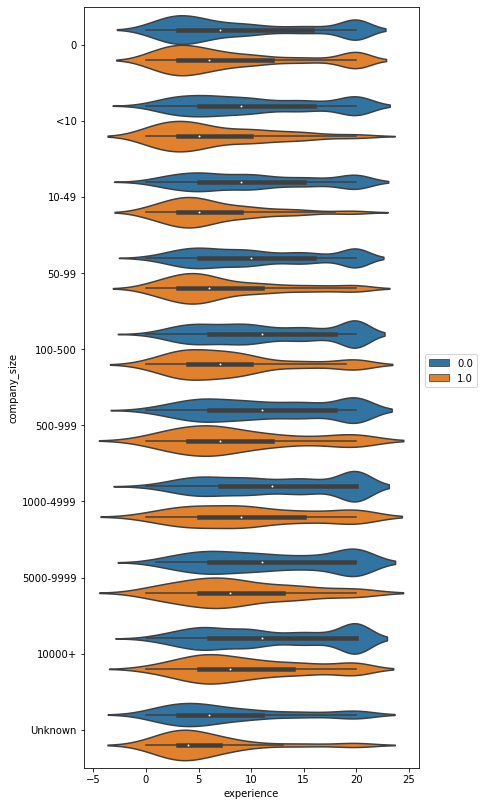

In [32]:
plt.figure(figsize=(6,14))
sns.violinplot(data=df_train,x='experience',y='company_size',order=['0','<10','10-49','50-99','100-500','500-999','1000-4999','5000-9999','10000+','Unknown'],hue='target')
plt.legend(loc=(1.02,0.5))
plt.show()

In general, as we've seen before, job searchers tend to be less experienced then non-searchers. 

It is also evident that no matter the size of the company, they all have very experienced and less experienced data scientists working there.

#### Last New Job

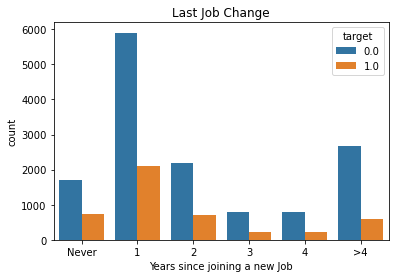

In [33]:
sns.countplot(data=df_train,x='last_new_job',hue='target',order=['Never','1','2','3','4','>4'])
plt.title('Last Job Change')
plt.xlabel('Years since joining a new Job')
plt.show()

Differently from what was supposed before, the time since last job change does not have a direct impact. Even among those who move for a new job in the last year we see many looking for a new job as well. This might be explained by the fact that the Tech companies tend to a high turnover.

#### Training Hours

We don't expect to see any relevant feature for the HR studies, as we've seen close to 0 correlation to the target, however, it is still interesting to see the distribution of training hours completed for the poeple taking courses on the company.<br>
This might not help much to predict if he is looking for a new job, but might help other teams on the company, as marking or even teachers. 

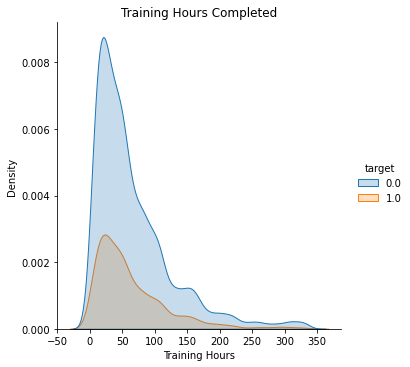

In [34]:
sns.displot(data=df_train,x='training_hours',kind='kde',hue='target',fill=True)
plt.title('Training Hours Completed')
plt.xlabel('Training Hours')
plt.show()

## 5. Classification Model <a name="prediction"></a>

### Preprocessing

The dataset will need some preprocessing before creating a model. 

- The categorical data need to be converted to dummie variables.
- Data must be scaled.
- Data imbalance must be dealt with.

Important to mention that both scaling and dealing with an imbalanced dataset must be done after splitting the data in order to avoid data leakage from the test data to the training data. 

In [35]:
df_train_copy=df_train.copy()

In [36]:
df_train_copy.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,No enrollment,Graduate,STEM,20.0,0,None,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,No enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5.0,0,None,Never,83,0.0
3,33241,city_115,0.789,Male,No relevent experience,No enrollment,Graduate,Business Degree,0.0,Unknown,Pvt Ltd,Never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,No enrollment,Masters,STEM,20.0,50-99,Funded Startup,4,8,0.0


In [37]:
df_train_copy=pd.get_dummies(df_train_copy,drop_first=True)

In [38]:
df_train_copy.head()

,enrollee_id,city_development_index,experience,training_hours,target,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,city_city_105,city_city_106,city_city_107,city_city_109,city_city_11,city_city_111,city_city_114,city_city_115,city_city_116,city_city_117,city_city_118,city_city_12,city_city_120,city_city_121,city_city_123,city_city_126,city_city_127,city_city_128,city_city_129,city_city_13,city_city_131,city_city_133,city_city_134,city_city_136,city_city_138,city_city_139,city_city_14,city_city_140,city_city_141,city_city_142,city_city_143,city_city_144,city_city_145,city_city_146,city_city_149,city_city_150,city_city_152,city_city_155,city_city_157,city_city_158,city_city_159,city_city_16,city_city_160,city_city_162,city_city_165,city_city_166,city_city_167,city_city_171,city_city_173,city_city_175,city_city_176,city_city_179,city_city_18,city_city_180,city_city_19,city_city_2,city_city_20,city_city_21,city_city_23,city_city_24,city_city_25,city_city_26,city_city_27,city_city_28,city_city_30,city_city_31,city_city_33,city_city_36,city_city_37,city_city_39,city_city_40,city_city_41,city_city_42,city_city_43,city_city_44,city_city_45,city_city_46,city_city_48,city_city_50,city_city_53,city_city_54,city_city_55,city_city_57,city_city_59,city_city_61,city_city_62,city_city_64,city_city_65,city_city_67,city_city_69,city_city_7,city_city_70,city_city_71,city_city_72,city_city_73,city_city_74,city_city_75,city_city_76,city_city_77,city_city_78,city_city_79,city_city_8,city_city_80,city_city_81,city_city_82,city_city_83,city_city_84,city_city_89,city_city_9,city_city_90,city_city_91,city_city_93,city_city_94,city_city_97,city_city_98,city_city_99,gender_Male,gender_Other,relevent_experience_No relevent experience,enrolled_university_No enrollment,enrolled_university_Part time course,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,company_size_10-49,company_size_100-500,company_size_1000-4999,company_size_10000+,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,company_size_Unknown,company_type_Funded Startup,company_type_NGO,company_type_None,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_Unknown,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_Never
0,8949,0.920,20.0,36,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,29725,0.776,15.0,47,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,11561,0.624,5.0,83,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,33241,0.789,0.0,52,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
4,666,0.767,20.0,8,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Splitting and Scaling the data

Data will be split and scaled with Standard Scaler.

Scaler must be fit to the training data and transformed on both train and test, once again to avoid data leakage.

In [39]:
X = df_train_copy.dropna().drop(columns=['target','enrollee_id'])
y = df_train_copy['target'].values

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [41]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Models

We will have our models in four different ways, comparing the performance:
- Standard model, with no hyperparameter tuning
- Hyperparameter tuning through Grid Search and Cross Validation
- Handling imbalanced data with SMOTE
- Handling imbalanced data with Borderline SMOTE

#### Standard Models

First, we will create our standard models and a list with them so we can iterate through each.

We will also creat a list for each metrics we will be controlling. 
- Accuracy
- Precision
- Recall
- F1 Score
- ROC AUC

In [42]:
log_reg = LogisticRegression(random_state=42)
knn=KNeighborsClassifier()
dt=DecisionTreeClassifier(random_state=42)
svc=SVC(random_state=42)
rfc=RandomForestClassifier(random_state=42)
abc = AdaBoostClassifier(random_state=42)
gbc=GradientBoostingClassifier(random_state=42)

In [43]:
classifier = [log_reg, knn, dt, svc, rfc, abc, gbc]

In [44]:
accuracy=[]
precision=[]
recall=[]
f1=[]
roc_auc=[]

Finally, we will define a function so we can call for each model to be run.

In [45]:
def run_model(model,i, X_train,X_test,y_train,y_test):
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)  
    
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))                 
    roc_auc.append(roc_auc_score(y_test, y_pred)) 
    
    print("Model: {}".format(model))
    print('\n')
    print("Accuracy: %{}".format(round(accuracy[i]*100,2)))
    print("Precision: {}".format(precision[i]))
    print("Recall: {}".format(recall[i]))
    print("F1-Score: {}".format(f1[i]))
    print("ROC AUC: {}".format(roc_auc[i]))
    print('\nConfusion Matrix') 
    print(confusion_matrix(y_test,y_pred))
    print('\n')
    print(classification_report(y_test,y_pred))
    print("\n---------------------------------------------------------------------------\n")

In [46]:
for i,model in enumerate(classifier):
    run_model(model,i,X_train,X_test,y_train,y_test)

Model: LogisticRegression(random_state=42)


Accuracy: %78.24
Precision: 0.6091127098321343
Recall: 0.3615658362989324
F1-Score: 0.4537740062527914
ROC AUC: 0.6421206790602821

Confusion Matrix
[[3890  326]
 [ 897  508]]


              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      4216
         1.0       0.61      0.36      0.45      1405

    accuracy                           0.78      5621
   macro avg       0.71      0.64      0.66      5621
weighted avg       0.76      0.78      0.76      5621


---------------------------------------------------------------------------

Model: KNeighborsClassifier()


Accuracy: %76.61
Precision: 0.5382653061224489
Recall: 0.4505338078291815
F1-Score: 0.4905075552111584
ROC AUC: 0.6608693707077596

Confusion Matrix
[[3673  543]
 [ 772  633]]


              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      4216
         1.0       0.54      0.45      0.49      1405

We will group the metrics obtained to better compare them.

In [47]:
standard_results=pd.DataFrame(list(zip(accuracy, precision, recall, f1, roc_auc)),
             columns=['Accuracy','Precision','Recall','F1 Score','ROC AUC'],
            index=['Std Logistic Regression', 'Std KNN', 'Std Decision Tree','Std SVC','Std Random Forest','Std Ada Boost','Std Gradient Boosting'])

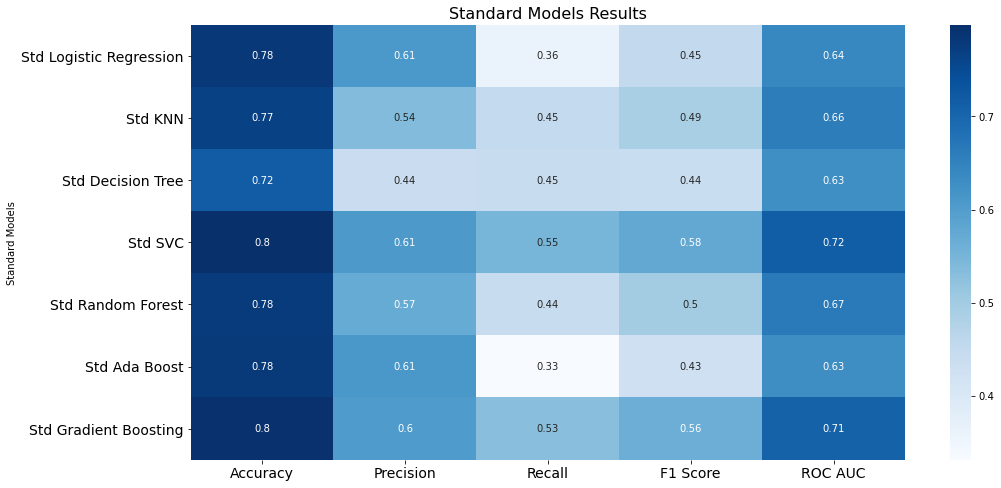

In [48]:
plt.figure(figsize=(16,8))
sns.heatmap(standard_results,annot=True,cmap = "Blues")
plt.xticks(size = 14)
plt.yticks(size = 14, rotation = 0)
plt.ylabel("Standard Models")
plt.title("Standard Models Results", size = 16)
plt.show()

Without hyperparameter tuning we got SVC and Gradient Boosting as our best performances,very similar one from the other. 

However, we see that for most of the models, and even for the best two models, the recall and therefore the F1 Score were very low. This poor recall performance was expected since we are working with an imbalanced dataset.

We will see if we are able to improve it by simply tuning the parameters.

#### Hyperparameter Tuning

Now we will verify the performance of the classifiers through hyperparameter tuning and Cross Validation.

Once again we will create a function to be called for each model, but we will also define our parameters and create a Grid Search for each. F1 Score will be used for scoring, trying to increase the recall obtained on the standard models without loosing much performance on precision. 

In [49]:
log_reg = LogisticRegression(max_iter=10000,random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
svc = SVC(random_state=42)
rfc = RandomForestClassifier(random_state=42)
abc = AdaBoostClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

In [50]:
classifier = [log_reg, knn, dt, svc, rfc, abc, gbc]

In [51]:
log_reg_param = {"C":np.logspace(-4, 4, 10), 
                 "penalty": ["elasticnet"],
                "l1_ratio":[0,0.1,0.5,0.9,1],
                "solver":['saga']}

knn_param = {"n_neighbors": np.linspace(2,20,12, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan","minkowski"],
                 "leaf_size": [1,3,5,12,30]}

dt_param = {"min_samples_split" : range(10,500,20), 
            "max_depth": range(1,15,2),
            "criterion" :['gini', 'entropy']}

svc_param = {"kernel" : ["rbf","sigmoid"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [0.001,0.01,0.1, 1,10,100,1000]}

rfc_param = {'max_features': ['auto', 'sqrt'],
                'max_depth' : [6,8,10,12],
                "bootstrap":[False],
                "n_estimators":[100,300,500],
                "criterion":["gini"]}

abc_param = {"n_estimators":range(1,50)}

gbc_param = {
    "learning_rate": [0.05, 0.1, 0.2],
    "min_samples_split": [2,3,10],
    "min_samples_leaf": [1,3,10]
    }

In [52]:
classifier_param = [log_reg_param, knn_param, dt_param, svc_param, rfc_param, abc_param, gbc_param]

In [53]:
cv_result = []
best_estimators = []
accuracy=[]
recall=[]
precision=[]
f1=[]
roc_auc=[]

In [54]:
def run_grid(model,i, X_train,X_test,y_train,y_test):
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)  
    
    cv_result.append(model.best_score_)
    best_estimators.append(model.best_estimator_)
    
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))                 
    roc_auc.append(roc_auc_score(y_test, y_pred))

    print("Model: {}".format(classifier[i]))
    print("Grid: {}".format(model))
    print('\n')
    print("Accuracy: %{}".format(round(accuracy[i]*100,2)))
    print("Precision: {}".format(precision[i]))
    print("Recall: {}".format(recall[i]))
    print("F1-Score: {}".format(f1[i]))
    print("ROC AUC: {}".format(roc_auc[i]))
    print('\n') 
    print("Best Estimator: {}".format(best_estimators[i]))
    print('\nConfusion Matrix') 
    print(confusion_matrix(y_test,y_pred))
    print('\n')
    print(classification_report(y_test,y_pred))
    print("\n---------------------------------------------------------------------------\n")

In [55]:
for i in range(len(classifier)):
    grid = GridSearchCV(classifier[i],
                       param_grid=classifier_param[i],
                       cv = 5,
                       scoring = "f1",
                       n_jobs = -1,
                       verbose = -2)

    run_grid(grid,i, X_train,X_test,y_train,y_test)

Model: LogisticRegression(max_iter=10000, random_state=42)
Grid: GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'l1_ratio': [0, 0.1, 0.5, 0.9, 1],
                         'penalty': ['elasticnet'], 'solver': ['saga']},
             scoring='f1', verbose=-2)


Accuracy: %78.26
Precision: 0.6095808383233533
Recall: 0.3622775800711744
F1-Score: 0.4544642857142857
ROC AUC: 0.6424765509464031


Best Estimator: LogisticRegression(C=2.782559402207126, l1_ratio=0, max_iter=10000,
                   penalty='elasticnet', random_state=42, solver='saga')

Confusion Matrix
[[3890  326]
 [ 896  509]]


              precision    recall  f1-score   support

         0.0       0.81      0.92    

In [56]:
cv_results=pd.DataFrame(list(zip(accuracy, precision, recall, f1, roc_auc)),
             columns=['Accuracy','Precision','Recall','F1 Score','ROC AUC'],
            index=['CV Logistic Regression', 'CV KNN', 'CV Decision Tree','CV SVC','CV Random Forest','CV Ada Boost','CV Gradient Boosting'])

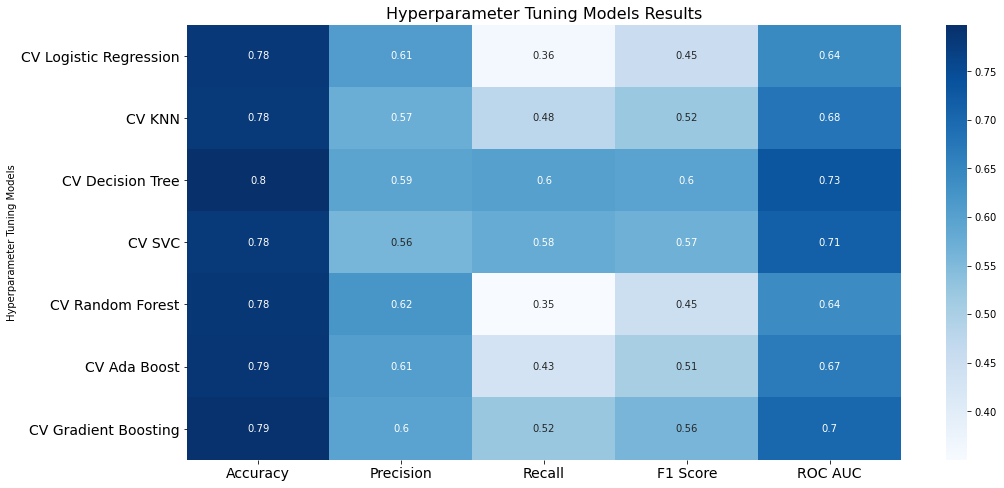

In [57]:
plt.figure(figsize=(16,8))
sns.heatmap(cv_results,annot=True,cmap = "Blues")
plt.xticks(size = 14)
plt.yticks(size = 14, rotation = 0)
plt.ylabel("Hyperparameter Tuning Models")
plt.title("Hyperparameter Tuning Models Results", size = 16)
plt.show()

By doing a hyperparameter tuning we were able to increase or at least keep a similar F1 Score for all the models, but there are still models with a low recall.

We will now try to increase it by doing a preprocessing step using an oversampling technique.

#### SMOTE

SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem.

It synthesizes new minority instances, new instances of the category that has fewer, between existing minority by linear interpolation beween them. 

This must be done after spliting the date, once we want to balance the training dataset for a better fit, we are not interested in testing a prediction of an instance we virtually created.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [59]:
X_train.shape

(13114, 160)

In [60]:
oversample = SMOTE()

In [61]:
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

In [62]:
X_train_resh.shape

(19792, 160)

After oversampling, similar to what we've done before, we will scale the data and have our list for loop and metrics defined.

Instead of running the Grid Search for all the values as done before, we will run the models with the best parameters found with cross validation only.

In a real life project it would be recommended to run a full grid search once again.

In [63]:
scaler = StandardScaler()

X_train_resh = scaler.fit_transform(X_train_resh)
X_test = scaler.transform(X_test)

In [64]:
log_reg = LogisticRegression(C=2.782559402207126, l1_ratio=0, max_iter=10000,penalty='elasticnet', random_state=42, solver='saga')
knn = KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=15)
dt = DecisionTreeClassifier(max_depth=7, min_samples_split=150, random_state=42)
svc = SVC(C=100, gamma=0.001, random_state=42)
rfc = RandomForestClassifier(bootstrap=False, max_depth=12, random_state=42)
abc = AdaBoostClassifier(n_estimators=1, random_state=42)
gbc = GradientBoostingClassifier(learning_rate=0.2, min_samples_leaf=3,min_samples_split=10, random_state=42)

In [65]:
classifier = [log_reg, knn, dt, svc, rfc, abc, gbc]

In [66]:
accuracy=[]
recall=[]
precision=[]
f1=[]
roc_auc=[]

In [67]:
for i,model in enumerate(classifier):
    run_model(model,i,X_train_resh,X_test,y_train_resh,y_test)

Model: LogisticRegression(C=2.782559402207126, l1_ratio=0, max_iter=10000,
                   penalty='elasticnet', random_state=42, solver='saga')


Accuracy: %78.62
Precision: 0.588646288209607
Recall: 0.4797153024911032
F1-Score: 0.5286274509803921
ROC AUC: 0.6839990174694606

Confusion Matrix
[[3745  471]
 [ 731  674]]


              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86      4216
         1.0       0.59      0.48      0.53      1405

    accuracy                           0.79      5621
   macro avg       0.71      0.68      0.70      5621
weighted avg       0.77      0.79      0.78      5621


---------------------------------------------------------------------------

Model: KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=15)


Accuracy: %78.31
Precision: 0.5664285714285714
Recall: 0.5644128113879003
F1-Score: 0.5654188948306595
ROC AUC: 0.7102187396597945

Confusion Matrix
[[3609  607]
 [ 612  793]]


           

In [68]:
SMOTE_results=pd.DataFrame(list(zip(accuracy, precision, recall, f1, roc_auc)),
             columns=['Accuracy','Precision','Recall','F1 Score','ROC AUC'],
            index=['SMOTE Logistic Regression', 'SMOTE KNN', 'SMOTE Decision Tree','SMOTE SVC','SMOTE Random Forest','SMOTE Ada Boost','SMOTE Gradient Boosting'])

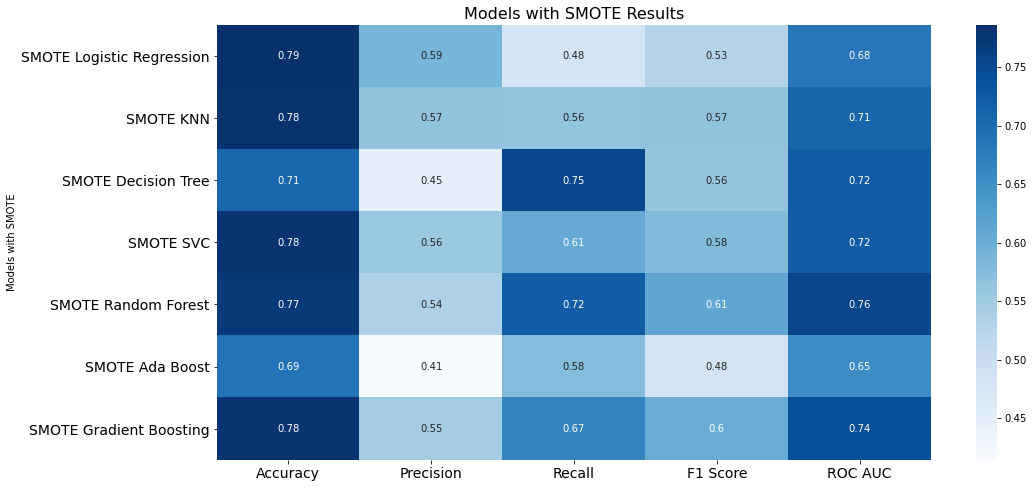

In [69]:
plt.figure(figsize=(16,8))
sns.heatmap(SMOTE_results,annot=True,cmap = "Blues")
plt.xticks(size = 14)
plt.yticks(size = 14, rotation = 0)
plt.ylabel("Models with SMOTE")
plt.title("Models with SMOTE Results", size = 16)
plt.show()

SMOTE was able to increase the recall and F1 Score for most of the models, without any new Cross Validation, assuming the same parameters as defined before. This increase of performance on recall was howerver done in exchange for a poorer performance on precision.

It was able to increase he Random Forest recall from 0.35 to 0.72, achieving the best ROC AUC and F1 Score. 

Gradient Boosting also had a good overall performance, even if it has a lower recall.

Decision tree got the highest recall, with a lower precision.

If we take a look on each confusion matrix obtained:


- Decision Tree

[2923 1293]

[ 347 1058]


- Random Forest

[3336  880]

[ 391 1014]


- Gradient Boosting


[3446  770]

[ 468  937]


Decision Tree was the model that was able to correctly predict the biggest number of Data Scientists looking for a job change.
Random Forest, on however, wrongly predicted 44 more instantes as not interested in changing, but correctly predicted 400 non-searchers more than Decision Tree did.

#### Borderline-SMOTE

The main difference between SMOTE and Borderline-SMOTE is that instead of generating new synthetic examples for the minority class "blindly", considering a linear interpolation between them, Borderline-SMOTE method selects those instances of the minority class that are more likely to be misclassified and creates synthetic examples along the decision boundary between the classes, trying to increase the resolution only where it is truly necessary.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [71]:
X_train.shape

(13114, 160)

In [72]:
oversample = BorderlineSMOTE()

In [73]:
X_train_resh_bord, y_train_resh_bord = oversample.fit_resample(X_train, y_train.ravel())

In [74]:
X_train_resh_bord.shape

(19792, 160)

In [75]:
scaler = StandardScaler()

X_train_resh_bord = scaler.fit_transform(X_train_resh_bord)
X_test = scaler.transform(X_test)

In [76]:
log_reg = LogisticRegression(C=2.782559402207126, l1_ratio=0, max_iter=10000,penalty='elasticnet', random_state=42, solver='saga')
knn = KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=15)
dt = DecisionTreeClassifier(max_depth=7, min_samples_split=150, random_state=42)
svc = SVC(C=100, gamma=0.001, random_state=42)
rfc = RandomForestClassifier(bootstrap=False, max_depth=12, random_state=42)
abc = AdaBoostClassifier(n_estimators=1, random_state=42)
gbc = GradientBoostingClassifier(learning_rate=0.2, min_samples_leaf=3,min_samples_split=10, random_state=42)

In [77]:
classifier = [log_reg, knn, dt, svc, rfc, abc, gbc]

In [78]:
accuracy=[]
recall=[]
precision=[]
f1=[]
roc_auc=[]

In [79]:
for i,model in enumerate(classifier):
    run_model(model,i,X_train_resh_bord,X_test,y_train_resh_bord,y_test)

Model: LogisticRegression(C=2.782559402207126, l1_ratio=0, max_iter=10000,
                   penalty='elasticnet', random_state=42, solver='saga')


Accuracy: %78.47
Precision: 0.5865128660159716
Recall: 0.47046263345195727
F1-Score: 0.5221169036334913
ROC AUC: 0.6799656620770222

Confusion Matrix
[[3750  466]
 [ 744  661]]


              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      4216
         1.0       0.59      0.47      0.52      1405

    accuracy                           0.78      5621
   macro avg       0.71      0.68      0.69      5621
weighted avg       0.77      0.78      0.78      5621


---------------------------------------------------------------------------

Model: KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=15)


Accuracy: %77.78
Precision: 0.5553191489361702
Recall: 0.5572953736654804
F1-Score: 0.5563055062166963
ROC AUC: 0.7042881042900457

Confusion Matrix
[[3589  627]
 [ 622  783]]


         

In [80]:
Bord_results=pd.DataFrame(list(zip(accuracy, precision,recall,  f1, roc_auc)),
             columns=['Accuracy','Precision','Recall','F1 Score','ROC AUC'],
            index=['Bord Logistic Regression', 'Bord KNN', 'Bord Decision Tree','Bord SVC','Bord Random Forest','Bord Ada Boost','Bord Gradient Boosting'])

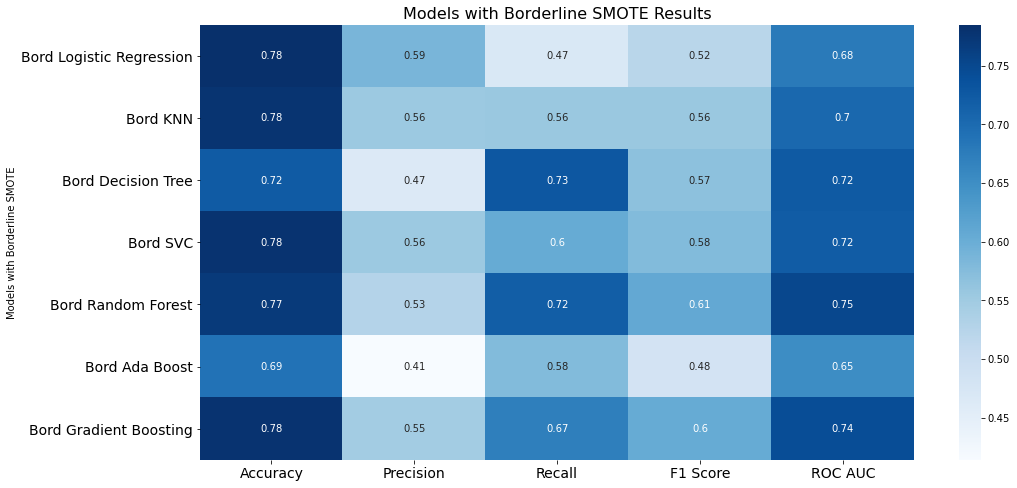

In [81]:
plt.figure(figsize=(16,8))
sns.heatmap(Bord_results,annot=True,cmap = "Blues")
plt.xticks(size = 14)
plt.yticks(size = 14, rotation = 0)
plt.ylabel("Models with Borderline SMOTE")
plt.title("Models with Borderline SMOTE Results", size = 16)
plt.show()

Borderline SMOTE was also able to greatly increase the recall when compared to models with no oversampling, achieving similar results to the ones obtained with SMOTE. For some models when comparing the the confusion matrix we see that Borderline SMOTE was able to slightly increase the recall for people looking for a job change.

### Comparing all the models

We can now join all the results to compare the best models obtained.

In [82]:
concatenate = [standard_results, cv_results, SMOTE_results, Bord_results]

result = pd.concat(concatenate)

result=result.reset_index()

result['Condition']=result['index'].apply(lambda x: x.split(" ", 1)[0])
result['Model']=result['index'].apply(lambda x: x.split(" ", 1)[1])


We will order our results by type of model and each model will be ordered by the F1 Score obtained.

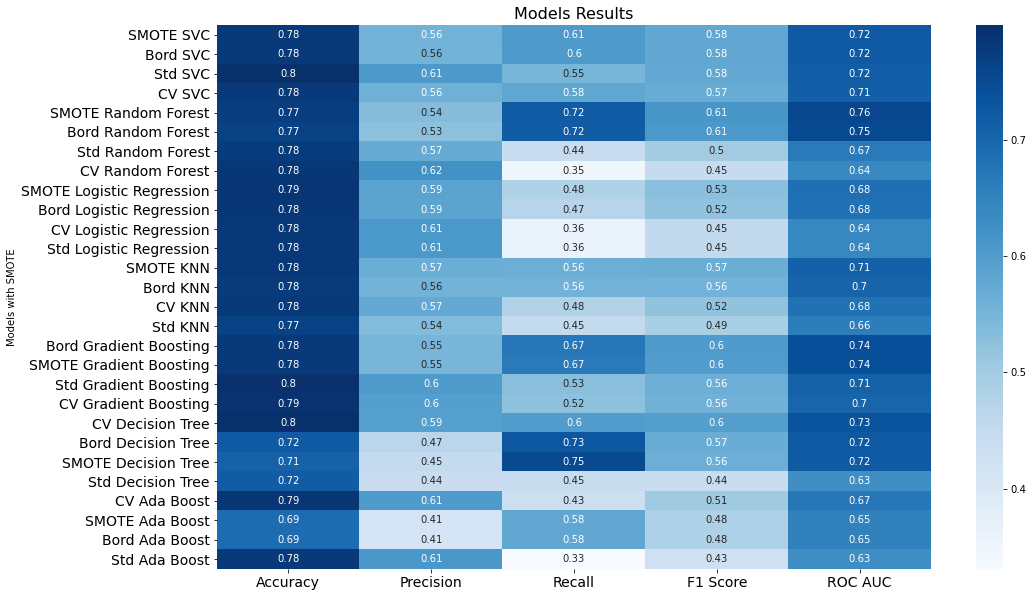

In [84]:
plt.figure(figsize=(16,10))
sns.heatmap(result.sort_values(['Model','F1 Score'], ascending=False)[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']],annot=True,cmap = "Blues")
plt.xticks(size = 14)
plt.yticks(size = 14, rotation = 0)
plt.ylabel("Models")
plt.title("Models Results", size = 16)
plt.show()

Looking at all the models scores together we can see that the two oversampling methods were able to significantly increase the recall in all the cases when compared to the models with no oversampling.

For some of the models, the increase of recall came with a big decrease of precision. 

The Random Forest with SMOTE oversampling has the higher ROC AUC obtained, a great recall and the highest F1 Score as well, so we will chose it as our best estimator.

It is important to mention that we are looking for recall instead of accuracy or precision, because we are working with a very imbalanced dataset and HR is more interested in identify the Data Scientists that are looking for a job change, even if we do miss more of those that are not. It wouldn't be a good model if we got 100% of the biggest class (not looking) but missed most of the ones that are interested in changing.

### Best Estimator

Finally, with our best model selected, we will defined it so we can predict the results for new data.

In [85]:
classifier = RandomForestClassifier(bootstrap=False, max_depth=12, random_state=42)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [87]:
oversample = SMOTE()

In [88]:
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

In [89]:
scaler = StandardScaler()

X_train_resh = scaler.fit_transform(X_train_resh)
X_test = scaler.transform(X_test)

In [90]:
classifier.fit(X_train_resh,y_train_resh)
y_pred = classifier.predict(X_test)

In [91]:
print('Confusion Matrix\n')
print(confusion_matrix(y_test,y_pred))
print('\nClassification Report\n')
print(classification_report(y_test,y_pred))
print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, y_pred),3)))
print("Recall: {}".format(round(recall_score(y_test, y_pred),3)))
print("F1 Score: {}".format(round(f1_score(y_test, y_pred),3)))
print("ROC AUC: {}".format(round(roc_auc_score(y_test, y_pred),3)))


Confusion Matrix

[[3331  885]
 [ 390 1015]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.90      0.79      0.84      4216
         1.0       0.53      0.72      0.61      1405

    accuracy                           0.77      5621
   macro avg       0.71      0.76      0.73      5621
weighted avg       0.80      0.77      0.78      5621

Accuracy: 0.773
Precision: 0.534
Recall: 0.722
F1 Score: 0.614
ROC AUC: 0.756


We have now our model defined and our metrics established as well.

### Price prediction of Test.csv using Best Estimator

With our model created, once it was deployed we would be able to call it for predicting if a data scientist is looking for a job change or not.

The raw data for predictions however still need some preprocessing.

In [92]:
df_test = pd.read_csv('aug_test.csv')

In [93]:
df_test.isnull().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

In [94]:
df_test.duplicated().sum()

0

As expected, the same preprocessing done for the training dataset will be necessary here.

Luckily we have a function already created for cleaning it.

In [95]:
clean_NAN(df_test)

We will also need to convert the categories into dummy variables.

In [96]:
df_test=pd.get_dummies(df_test,drop_first=True)

In [97]:
test = df_test.drop(columns=['enrollee_id'])

Since the test dataset does not necessarilly have instances belonging to every city we had on our training dataset, we are probably going to have fewer columns than we did before. This will be be fixed bellow. 

In [98]:
column_list=[]
for column in X_train.columns.tolist():
    if column not in test.columns.tolist():
        column_list.append(column)
        
missing_columns=pd.DataFrame(columns=column_list)
test = pd.concat([test, missing_columns], axis=1)
test.fillna('0',inplace=True)
test=test[X_train.columns.tolist()]

Finally, we can scale - only transforming, not fitting, using the same scaler fit on the training step - and predict outputs.

In [99]:
test = scaler.transform(test)

In [100]:
prediction = classifier.predict(test)

In [101]:
df_test['target']=prediction

In [102]:
df_test['target'].value_counts()

0.0    1392
1.0     697
Name: target, dtype: int64

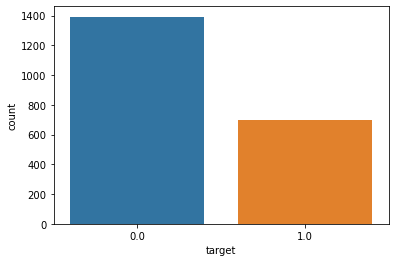

In [105]:
sns.countplot(data=df_test,x='target')
plt.show()

The model predicted that from the 2089 data scientists on this dataset, 697 are looking for a job change.

## 6. Conclusion <a name="conclusion"></a>

We have explored and visualized our data in interesting ways to get a more complete view of our data, dealing along the way with null values from the original dataset.

We also identified that candidades not currently working, with a low experience, living in a city with a development index smaller than 0.66, being enrolled in a full period course or being graduated may be indicatives that he is looking for a new job, so are the main factors to keep in mind at a first selection. 

Then, we performed several machine learning algorithms to try to predict whether or not someone would be a job seeker or not.
Models developed were:
- Logistic Linear Regression
- KNN
- Logistic Regression
- Decision tree
- Random forest
- Ada Boost
- Gradient Boosting

We first studied them with no paremeters, just the standard model.
Next, a Cross Validation was run to tune the hyperparameters of these models.
Then, we looked at addressing the imbalance in our data to see how this could improve our models' predictions.

I used SMOTE and re-trained all the models. The Random Forest model performed great.
Borderline SMOTE was also studied for the models, achieving very similar results, with a few models scoring better recalls.

We finally compared all the metrics we got, selecting Random Forest with SMOTE for oversampling as our best model, with these final scores:

Accuracy: 0.773<br>
Precision: 0.534<br>
Recall: 0.722<br>
F1 Score: 0.614<br>
ROC AUC: 0.756<br>

For the models trained with an oversampled training dataset we did not do model tuning, so the final score could almost certainly be improved, still, good results were achieved by assuming the same parameters we got on our Cross Validation without oversampling. 

Next step on this project would be to run a hyperparameter tuning.

At the end, we ran the model predicting whether the Data Scientists from a new dataset are looking for a job change or not.

## 7. References <a name="references"></a>

- HR Analytics - Job Change of Data Scientists: https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists
- SMOTE: https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/
- Borderline SMOTE: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
